<img src="files/Northwind_ERD_updated.png">

**Research question 1:** Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [1]:
import pandas as pd
import sqlite3
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
df = get_table(table='OrderDetail')

In [4]:
inspect_dataframe(df)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [5]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [6]:
# cur.execute("""SELECT * from OrderDetail""")

# df = pd.DataFrame(cur.fetchall())
# df.columns = [x[0] for x in cur.description]

# print(len(df))
# df.head()

In [7]:
discount_rates = set(df.Discount.values)

In [8]:
# avg_order_size = []
# for d in discount_rates:
#     mu = df[df['Discount'] == d]['Quantity'].mean()
#     avg_order_size.append(mu)
    
# avg_order_size

In [9]:
avg_discount_order_size = {}

for d in discount_rates: 
    avg_discount_order_size[d] = df[df['Discount'] == d]['Quantity'].mean()
    
avg_discount_order_size

{0.0: 21.715261958997722,
 0.25: 28.24025974025974,
 0.2: 27.024844720496894,
 0.05: 28.01081081081081,
 0.15: 28.38216560509554,
 0.1: 25.23699421965318,
 0.03: 1.6666666666666667,
 0.06: 2.0,
 0.01: 2.0,
 0.04: 1.0,
 0.02: 2.0}

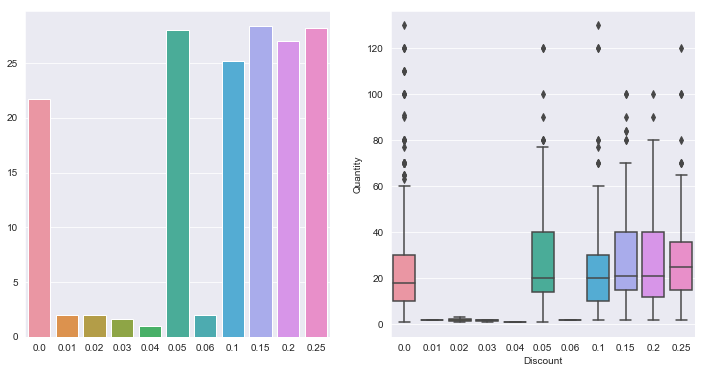

In [10]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

sns.barplot(x=list(avg_discount_order_size.keys()), y=list(avg_discount_order_size.values()), ax=ax1)
sns.boxplot(x=df.Discount, y=df.Quantity, data=df, ax=ax2)
plt.show()

**Record initial observations**

In [11]:
# df.ProductId.nunique()

In [12]:
# df.OrderId.nunique()

In [13]:
# len(df.OrderId)

**Does discount have an effect on order size? Break data into 2 groups: discount and no-discount**

In [14]:
no_d = np.array(df[df['Discount'] == 0.0]['Quantity'])
d = np.array(df[df['Discount'] != 0.0]['Quantity'])

In [15]:
compare_2(no_d,d)

The size of group1 is: 1317  	  The size of group2 is 838
The mean of group1 is: 21.715261958997722 	  The mean of group2 is: 27.10978520286396
The std of group1 is: 17.500845477669806 	  The std of group2 is: 20.759042075141373


* record some observations

visually inspect

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


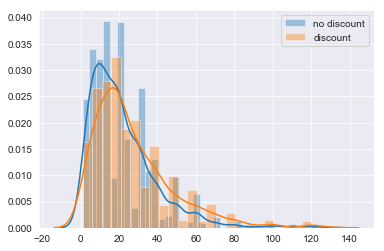

In [16]:
sns.distplot(no_d, label='no discount')
sns.distplot(d, label='discount')
plt.legend()

We've given it a good look, reiterate observations and make some hypotheses

**Null Hypothesis (H0): There is no relationship between discount and quantity ordered**

**Alternative Hypothesis (Ha): There is a positive relationship between discount and quantity ordered - a discount is likely to result in a larger order**

To ensure we have a stisitcally significant effect we'll get for a 95% level of confidence, and set **alpha to .05**

In [17]:
alpha=.05

In order to accept or reject H0 we will conduct a statistical test to see if the quantities ordered with a discount are statistically significantly greater than our baseline orders, or, orders with no discount. 

We can test our hypothesis with a one-sided t-test. Both of our groups of data are independent of one another, that is to say that quantity ordered per order in one group should not be affected by quantity ordered in the other. Therefore we will do an independent t-test with. 

But, first we must check our assumptions of normality for each group to determine if we need to sample. We'll do this with the shapiro-wilke test for normality. 

In [18]:
test_normality(d)
test_normality(no_d)

p = 6.88120409395894e-26 	 Therefore the data is not normal
p = 3.803856556577728e-34 	 Therefore the data is not normal


False

It looks like our data are not normally distributed. We'll need to sample from them to see if we can arrive at a more normal distribution to run our tests on. Let's draw those samples and test for normality again. 

In [19]:
no_discount_sample = random_sample(no_d)
discount_sample = random_sample(d)

test_normality(no_discount_sample)
test_normality(discount_sample)

p = 0.6017782092094421 	 Therefore the data is normal
p = 0.04122881218791008 	 Therefore the data is not normal


False

Awesome, it looks like the Central Limit Theorem wins again! By drawing a series of random samples and obtaining their means we have identified a more normally distributed set of data. We can now move forward and check our variance assumption next, but first let's get a quick visual representation of our data now.   

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


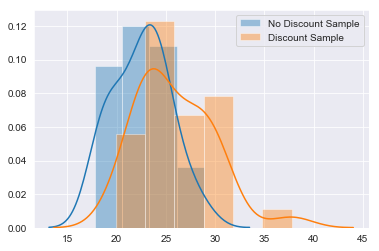

In [20]:
sns.distplot(no_discount_sample, label='No Discount Sample')
sns.distplot(discount_sample, label='Discount Sample')
plt.legend()

Now let's check to see if we have equal variance among our sample groups, that will determine which type of t-test we should perform. We'll do this using Levene's test for equal variance. 

In [21]:
test_variance(no_discount_sample, discount_sample)

p = 0.16503582212453316 	 Therefore the data has equal variances


True

Our samples have sufficiently equal variance, we'll therefore use the Student's T-Test to compare the two groups. We'll be looking for a p-value of less than .05 if we want to reject our null hypothesis.  

In [22]:
p = stats.ttest_ind(no_discount_sample, discount_sample, axis=0, equal_var=True)[1]

check_null_hypothesis(p,alpha=alpha)

With a p-value of 0.0003349809349340191, which is less than 0.05 we can reject the H0 and accept Ha


False

It appears that for now we can reject the null hypothesis and conclude that there is a statistically significant and positive difference between quantities ordered with a discount than without a discount. There is a very low probability of a type 1 error, meaning that our results are due to random chance and that there is in fact not a positive effect on order size with a discount. 

In order to ensure that our results are as accurate as possible we can check the effect and power of our conclusions.

In [23]:
# check effect size with cohen's d
discount_effect = cohen_d(no_discount_sample, discount_sample)
discount_effect

1.0013290854942052

This is a fairly large effect size, reinforcing our conclusion to reject H0. We can use effect size to check the statistical power of our results as well. Here we will be looking for a power larger than .8, which tells us that our number of observations were large enough to draw our conclusions from at this level of alpha. 

In [24]:
from statsmodels.stats.power import TTestIndPower
power = TTestIndPower()

In [25]:
power.solve_power(effect_size=discount_effect, nobs1=len(discount_sample), alpha=alpha, alternative='larger')

0.9856461545050781

We have the power! It looks like our sample size is sufficiently big enough to detect an effect given our degree of confidence as set by alpha. 

With this, we can again affirm our conclusion to reject H0 and determine that discounts do indeed have a positive effect on quantity ordered. 

We can now move on to answering the second part of our question, which discount rates in fact have and effect on quantities ordered? First we can check to see if there is a significant difference among rates by conducting an ANOVA analysis. 

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount),21258.403604,10.0,6.011811,4.704231e-09
Residual,758141.232591,2144.0,NaN,NaN


With a very low p-value (4.7 e-09) we can conclude that there is in fact a difference among discount rates. Let's check the levels of significance for each category of discount. 

In [27]:
lm.pvalues

Intercept              6.746766e-281
C(Discount)[T.0.01]     2.947414e-01
C(Discount)[T.0.02]     1.385988e-01
C(Discount)[T.0.03]     6.524250e-02
C(Discount)[T.0.04]     2.709368e-01
C(Discount)[T.0.05]     2.095341e-05
C(Discount)[T.0.06]     2.947414e-01
C(Discount)[T.0.1]      2.065861e-02
C(Discount)[T.0.15]     2.789428e-05
C(Discount)[T.0.2]      7.326710e-04
C(Discount)[T.0.25]     4.781032e-05
dtype: float64

Recalling from our earlier value counts that there were very few observations for rates from 0.01-0.04, and only one for 0.06, we can disregard those as we do not have a large enough sample to determine statistical significance.

That leaves us with .05, .1, .15, .2 and .25. each of which appear to have a low enough p-value to suggest further analysis. 

To do this we will do post hoc t-tests with the Bonferroni correction. We will sample each group as before and compare them to the control sample (no discount). 

First, lets establish our new level of alpha by applying Bonferroni. 

In [28]:
b_alpha = bonferroni_alpha(obs=5, alpha=alpha)
b_alpha

0.01

Now we will need to create sample for each of our discount levels and test for normality and variance

In [29]:
five_sample = random_sample(df[df['Discount'] == .05]['Quantity'])
ten_sample = random_sample(df[df['Discount'] == .1]['Quantity'])
fifteen_sample = random_sample(df[df['Discount'] == .15]['Quantity'])
twenty_sample = random_sample(df[df['Discount'] == .2]['Quantity'])
twentyfive_sample = random_sample(df[df['Discount'] == .25]['Quantity'])

samples = [five_sample, ten_sample, fifteen_sample, twenty_sample, twentyfive_sample]

for s in samples:
    test_normality(s)

print('\n')    

for s in samples:
    test_variance(s, no_discount_sample)

p = 0.8990324139595032 	 Therefore the data is normal
p = 0.4962656497955322 	 Therefore the data is normal
p = 0.8913663029670715 	 Therefore the data is normal
p = 0.00997146125882864 	 Therefore the data is not normal
p = 0.12406059354543686 	 Therefore the data is normal


p = 0.037387566235023525 	 Therefore the data do not have equal variances
p = 0.2533808151598783 	 Therefore the data has equal variances
p = 0.040902413038355706 	 Therefore the data do not have equal variances
p = 0.04296113759086339 	 Therefore the data do not have equal variances
p = 0.30894432368767843 	 Therefore the data has equal variances


By sampling for each discount level we've satisfied our normality and variance assumptions, now we can conduct t-tests with our new confidence level set by the Bonferroni Correction, and check for effect sizes and power levels as well. 

In [30]:
for s in samples:
    p = stats.ttest_ind(no_discount_sample, s, axis=0, equal_var=True)[1]
    check_null_hypothesis(p, alpha=b_alpha)

With a p-value of 1.2908071046395533e-07, which is less than 0.01 we can reject the H0 and accept Ha
With a p-value of 0.030883654087530587, which is greater than 0.01, at this time we fail to reject the H0
With a p-value of 1.7492299486729346e-06, which is less than 0.01 we can reject the H0 and accept Ha
With a p-value of 8.458623610270962e-08, which is less than 0.01 we can reject the H0 and accept Ha
With a p-value of 7.297099261246252e-11, which is less than 0.01 we can reject the H0 and accept Ha


In [31]:
effect = []
for s in samples:
    effect.append(cohen_d(no_discount_sample,s))
effect

[1.5794381136901918,
 0.5810287204653163,
 1.3968681257735167,
 1.6086102752516886,
 2.0889868195316152]

In [32]:
for e in effect: 
    print(power.solve_power(effect_size=e, nobs1=30, alpha=b_alpha))

0.9996133415704131
0.34840077905555156
0.9962810475756411
0.999741408220526
1.0


In [33]:
power.solve_power(effect_size=.8, power=.8, alpha=.05)

25.52457250047935

**Conclusions for question 1**

## Next Question

In [34]:
cursor.execute('select name from sqlite_master where type ="table"').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

Potential questions:
* Which employee sells the most by quantity?
* Which employee sells the most by revenue? 
* Which employee uses discounts the most? 
* Do discounts have greater effects on some products than others? 
* Does unit price have an effect on order size or discount size? 
* 

In [35]:
OrderDetail = get_table(table = 'OrderDetail')
OrderDetail.head ()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [36]:
cur.execute("""SELECT Id, EmployeeId
               FROM 'Order' """)

Order = pd.DataFrame(cur.fetchall())
Order.columns = [x[0] for x in cur.description]

print(len(Order))
Order.head()

830


,Id,EmployeeId
0,10248,5
1,10249,6
2,10250,4
3,10251,3
4,10252,4


In [37]:
df2 = pd.merge(OrderDetail, Order, left_on='OrderId', right_on='Id', how='left')
inspect_dataframe(df2)

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId
0,10248/11,10248,11,14.0,12,0.0,10248,5
1,10248/42,10248,42,9.8,10,0.0,10248,5
2,10248/72,10248,72,34.8,5,0.0,10248,5
3,10249/14,10249,14,18.6,9,0.0,10249,6
4,10249/51,10249,51,42.4,40,0.0,10249,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id_x          2155 non-null object
OrderId       2155 non-null int64
ProductId     2155 non-null int64
UnitPrice     2155 non-null float64
Quantity      2155 non-null int64
Discount      2155 non-null float64
Id_y          2155 non-null int64
EmployeeId    2155 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 151.5+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,10659.375870,4.333179
std,241.378032,22.159019,29.827418,19.022047,0.083450,241.378032,2.490351
min,10248.000000,1.000000,2.000000,1.000000,0.000000,10248.000000,1.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,10451.000000,2.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,10657.000000,4.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,10862.500000,7.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,11077.000000,9.000000


In [38]:
formula = 'Quantity ~ C(EmployeeId)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),4643.183282,8.0,1.607646,0.11745
Residual,774756.452913,2146.0,NaN,NaN


In [40]:
formula = 'Discount ~ C(EmployeeId)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),0.16041,8.0,2.899611,0.003232
Residual,14.83993,2146.0,NaN,NaN


In [50]:
# Create a new column called y_discount where the value is 1
# if Discount is greater than 0.0 and 0 if not
df2['y_discount'] = np.where(df2['Discount'] > 0.0, 1, 0)
df2.head()

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId,y_discount
0,10248/11,10248,11,14.0,12,0.0,10248,5,0
1,10248/42,10248,42,9.8,10,0.0,10248,5,0
2,10248/72,10248,72,34.8,5,0.0,10248,5,0
3,10249/14,10249,14,18.6,9,0.0,10249,6,0
4,10249/51,10249,51,42.4,40,0.0,10249,6,0


In [51]:
df2.y_discount.value_counts()

0    1317
1     838
Name: y_discount, dtype: int64

In [52]:
formula = 'y_discount ~ C(EmployeeId)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),6.241641,8.0,3.309646,0.000914
Residual,505.891073,2146.0,NaN,NaN


In [62]:
df2[df2['EmployeeId'] == 1]['Quantity'].mean() 

22.643478260869564

In [65]:
employees = list(range(1,10))
for e in employees:
    print(f"Employee {e} sells an average of {df2[df2['EmployeeId'] == e]['Quantity'].mean()} per sale")

Employee 1 sells an average of 22.643478260869564 per sale
Employee 2 sells an average of 25.12448132780083 per sale
Employee 3 sells an average of 24.461059190031154 per sale
Employee 4 sells an average of 23.32857142857143 per sale
Employee 5 sells an average of 25.94871794871795 per sale
Employee 6 sells an average of 20.99404761904762 per sale
Employee 7 sells an average of 26.443181818181817 per sale
Employee 8 sells an average of 22.74230769230769 per sale
Employee 9 sells an average of 24.953271028037385 per sale


In [60]:
df2.EmployeeId.value_counts()

4    420
1    345
3    321
8    260
2    241
7    176
6    168
5    117
9    107
Name: EmployeeId, dtype: int64

p = 0.5380761623382568 	 Therefore the data is normal


/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


True

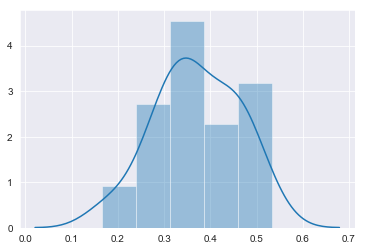

In [58]:
pop_sample = random_sample(df2.y_discount)
sns.distplot(pop_sample)
test_normality(pop_sample)

p = 0.23351959884166718 	 Therefore the data is normal


/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


True

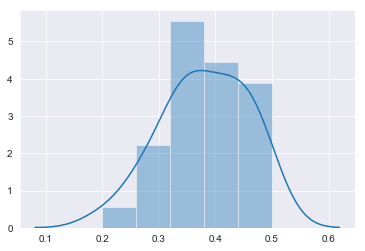

In [66]:
emp1_samp = random_sample(df2[df2['EmployeeId'] == 1]['y_discount'])
sns.distplot(emp1_samp)
test_normality(emp1_samp)

In [67]:
test_variance(pop_sample, emp1_samp)

p = 0.4744628542999749 	 Therefore the data has equal variances


True

In [72]:
xu = mean(pop_sample)

In [76]:
check_null_hypothesis(stats.ttest_1samp(emp1_samp, xu)[1])

With a p-value of 0.4336947879259312, which is greater than 0.05, at this time we fail to reject the H0


True

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


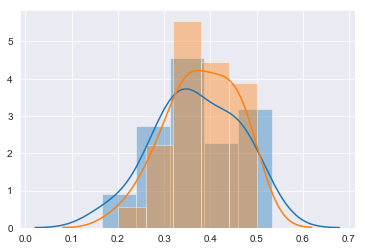

In [78]:
sns.distplot(pop_sample)
sns.distplot(emp1_samp)

In [83]:
employees = list(range(1,10))
for e in employees:
    print(f"""Employee {e} uses a discount {round(df2[df2['EmployeeId'] == e]['y_discount'].mean(), 3)}% of the time.""")

Employee 1 uses a discount 0.391% of the time.
Employee 2 uses a discount 0.315% of the time.
Employee 3 uses a discount 0.324% of the time.
Employee 4 uses a discount 0.405% of the time.
Employee 5 uses a discount 0.504% of the time.
Employee 6 uses a discount 0.411% of the time.
Employee 7 uses a discount 0.477% of the time.
Employee 8 uses a discount 0.362% of the time.
Employee 9 uses a discount 0.439% of the time.


In [88]:
emp_samples = {}
for e in employees:
    emp_samples[e] = random_sample(df2[df2['EmployeeId'] == e]['y_discount'])

In [101]:
for k in emp_samples:
    print(f'Employee {k}:'), test_normality(emp_samples[k])

Employee 1:
p = 0.6534451842308044 	 Therefore the data is normal
Employee 2:
p = 0.10485824197530746 	 Therefore the data is normal
Employee 3:
p = 0.1346586048603058 	 Therefore the data is normal
Employee 4:
p = 0.14021942019462585 	 Therefore the data is normal
Employee 5:
p = 0.15566176176071167 	 Therefore the data is normal
Employee 6:
p = 0.6108096241950989 	 Therefore the data is normal
Employee 7:
p = 0.21782134473323822 	 Therefore the data is normal
Employee 8:
p = 0.14653174579143524 	 Therefore the data is normal
Employee 9:
p = 0.1516793668270111 	 Therefore the data is normal


In [102]:
for k in emp_samples:
    print(f'Employee {k}:'), test_variance(emp_samples[k], pop_sample)

Employee 1:
p = 0.5917528162466931 	 Therefore the data has equal variances
Employee 2:
p = 0.5885904561143821 	 Therefore the data has equal variances
Employee 3:
p = 0.19064156329589013 	 Therefore the data has equal variances
Employee 4:
p = 0.944670237875018 	 Therefore the data has equal variances
Employee 5:
p = 0.6033467961220934 	 Therefore the data has equal variances
Employee 6:
p = 0.37479009231729665 	 Therefore the data has equal variances
Employee 7:
p = 0.8901330072993024 	 Therefore the data has equal variances
Employee 8:
p = 0.8117814082548908 	 Therefore the data has equal variances
Employee 9:
p = 0.516017892599611 	 Therefore the data has equal variances


In [188]:
test_df = pd.DataFrame.from_dict(emp_samples)
test_df.head()

,1,2,3,4,5,6,7,8,9
0,0.333333,0.366667,0.300000,0.400000,0.466667,0.366667,0.600000,0.300000,0.400000
1,0.233333,0.233333,0.366667,0.433333,0.466667,0.400000,0.266667,0.400000,0.533333
2,0.366667,0.400000,0.333333,0.466667,0.566667,0.400000,0.500000,0.266667,0.400000
3,0.400000,0.366667,0.300000,0.733333,0.466667,0.400000,0.466667,0.300000,0.466667
4,0.333333,0.233333,0.400000,0.400000,0.433333,0.366667,0.433333,0.366667,0.466667


In [189]:
import math

In [211]:
def get_distplots(df, comparison, cols=1):
    rows = math.ceil(len(df.columns)/cols)
    figwidth = 5 * cols
    figheight = 4 * rows
    
    fig, ax = plt.subplots(nrows = rows,
                          ncols = cols,
                          figsize = (figwidth, figheight))
    
    ax = ax.ravel()
    
    for i, column in enumerate(df.columns):
        sns.distplot(df[column], ax=ax[i], label=(f'Emp {column} Sample'))
        sns.distplot(comparison, ax=ax[i], label='Pop Sample')
    
    plt.legend()
    plt.show()
    
    

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


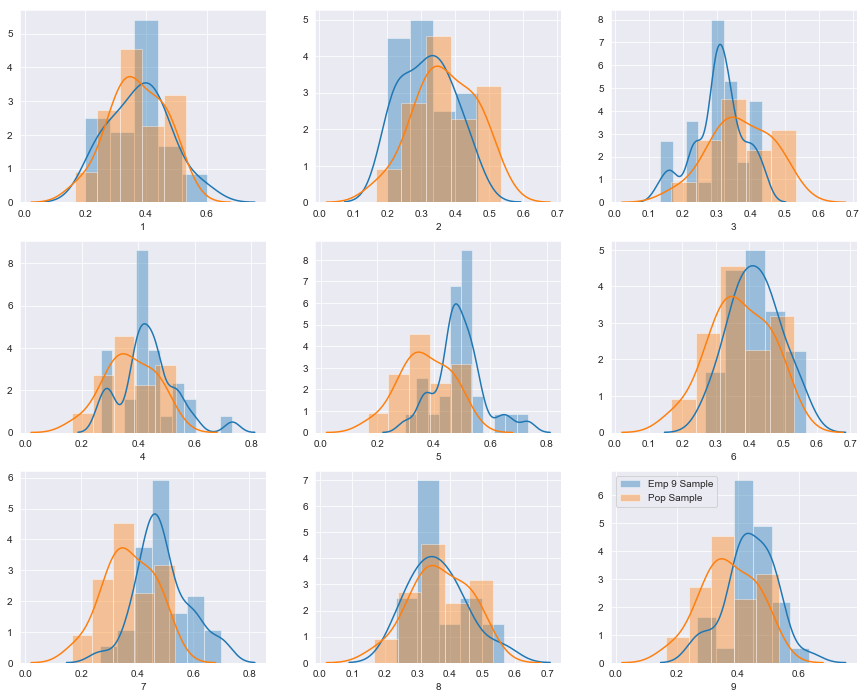

In [212]:
get_distplots(test_df, pop_sample, cols=3)

In [162]:
for k in emp_samples:
    print(f'Employee {k}:'), check_null_hypothesis(stats.ttest_1samp(emp_samples[k], xu)[1], alpha=.05)
    print(' ')

Employee 1:
With a p-value of 0.6730523473229295, which is greater than 0.05, at this time we fail to reject the H0
 
Employee 2:
With a p-value of 0.0008134440804507968, which is less than 0.05 we can reject the H0 and accept Ha
 
Employee 3:
With a p-value of 5.571187733994561e-05, which is less than 0.05 we can reject the H0 and accept Ha
 
Employee 4:
With a p-value of 0.0014044695387591477, which is less than 0.05 we can reject the H0 and accept Ha
 
Employee 5:
With a p-value of 3.7631319506638405e-08, which is less than 0.05 we can reject the H0 and accept Ha
 
Employee 6:
With a p-value of 0.001979991305904461, which is less than 0.05 we can reject the H0 and accept Ha
 
Employee 7:
With a p-value of 1.853493761935124e-07, which is less than 0.05 we can reject the H0 and accept Ha
 
Employee 8:
With a p-value of 0.7343538187111891, which is greater than 0.05, at this time we fail to reject the H0
 
Employee 9:
With a p-value of 5.4482208049534365e-05, which is less than 0.05 we

In [113]:
for k in emp_samples:
    print(f'Employee {k}:'), check_null_hypothesis(stats.ttest_ind(emp_samples[k], pop_sample,)[1], alpha=.05)

Employee 1:
With a p-value of 0.7533922848551645, which is greater than 0.05, at this time we fail to reject the H0
Employee 2:
With a p-value of 0.017780164260995667, which is less than 0.05 we can reject the H0 and accept Ha
Employee 3:
With a p-value of 0.003953160874692135, which is less than 0.05 we can reject the H0 and accept Ha
Employee 4:
With a p-value of 0.01076767888050108, which is less than 0.05 we can reject the H0 and accept Ha
Employee 5:
With a p-value of 2.700473234669014e-06, which is less than 0.05 we can reject the H0 and accept Ha
Employee 6:
With a p-value of 0.03413410062708331, which is less than 0.05 we can reject the H0 and accept Ha
Employee 7:
With a p-value of 6.580509173314281e-06, which is less than 0.05 we can reject the H0 and accept Ha
Employee 8:
With a p-value of 0.8113981770555492, which is greater than 0.05, at this time we fail to reject the H0
Employee 9:
With a p-value of 0.002379175041709868, which is less than 0.05 we can reject the H0 and a

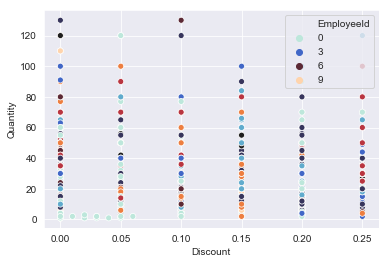

In [46]:
sns.scatterplot(x='Discount' , y='Quantity', hue='EmployeeId', data=df2, palette='icefire' )

In [148]:
df_group = pd.pivot_table(df2, values='Quantity', index= 'EmployeeId', aggfunc= [np.count_nonzero, np.sum, np.mean, np.std])
df_group

,count_nonzero,sum,mean,std
,Quantity,Quantity,Quantity,Quantity
EmployeeId,,,,
1,345,7812,22.643478,19.658357
2,241,6055,25.124481,21.164068
3,321,7852,24.461059,18.396651
4,420,9798,23.328571,18.105542
5,117,3036,25.948718,20.755907
6,168,3527,20.994048,16.694686
7,176,4654,26.443182,21.185093
8,260,5913,22.742308,17.480462


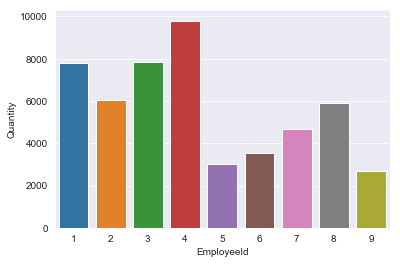

In [154]:
sns.barplot(x=df_group.index, y=df_group['sum']['Quantity'])

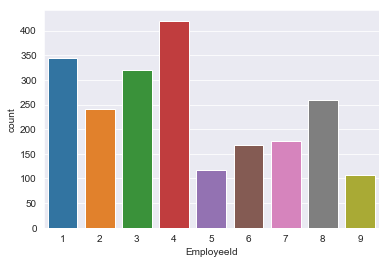

In [146]:
sns.countplot(x="EmployeeId", data=df2)

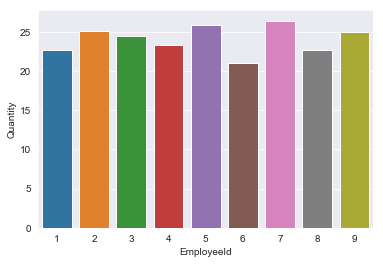

In [155]:
sns.barplot(x=df_group.index, y=df_group['mean']['Quantity'])